Maximum Vs: 368.00 m/s
Depth to Engineering Bedrock: 56.20 m


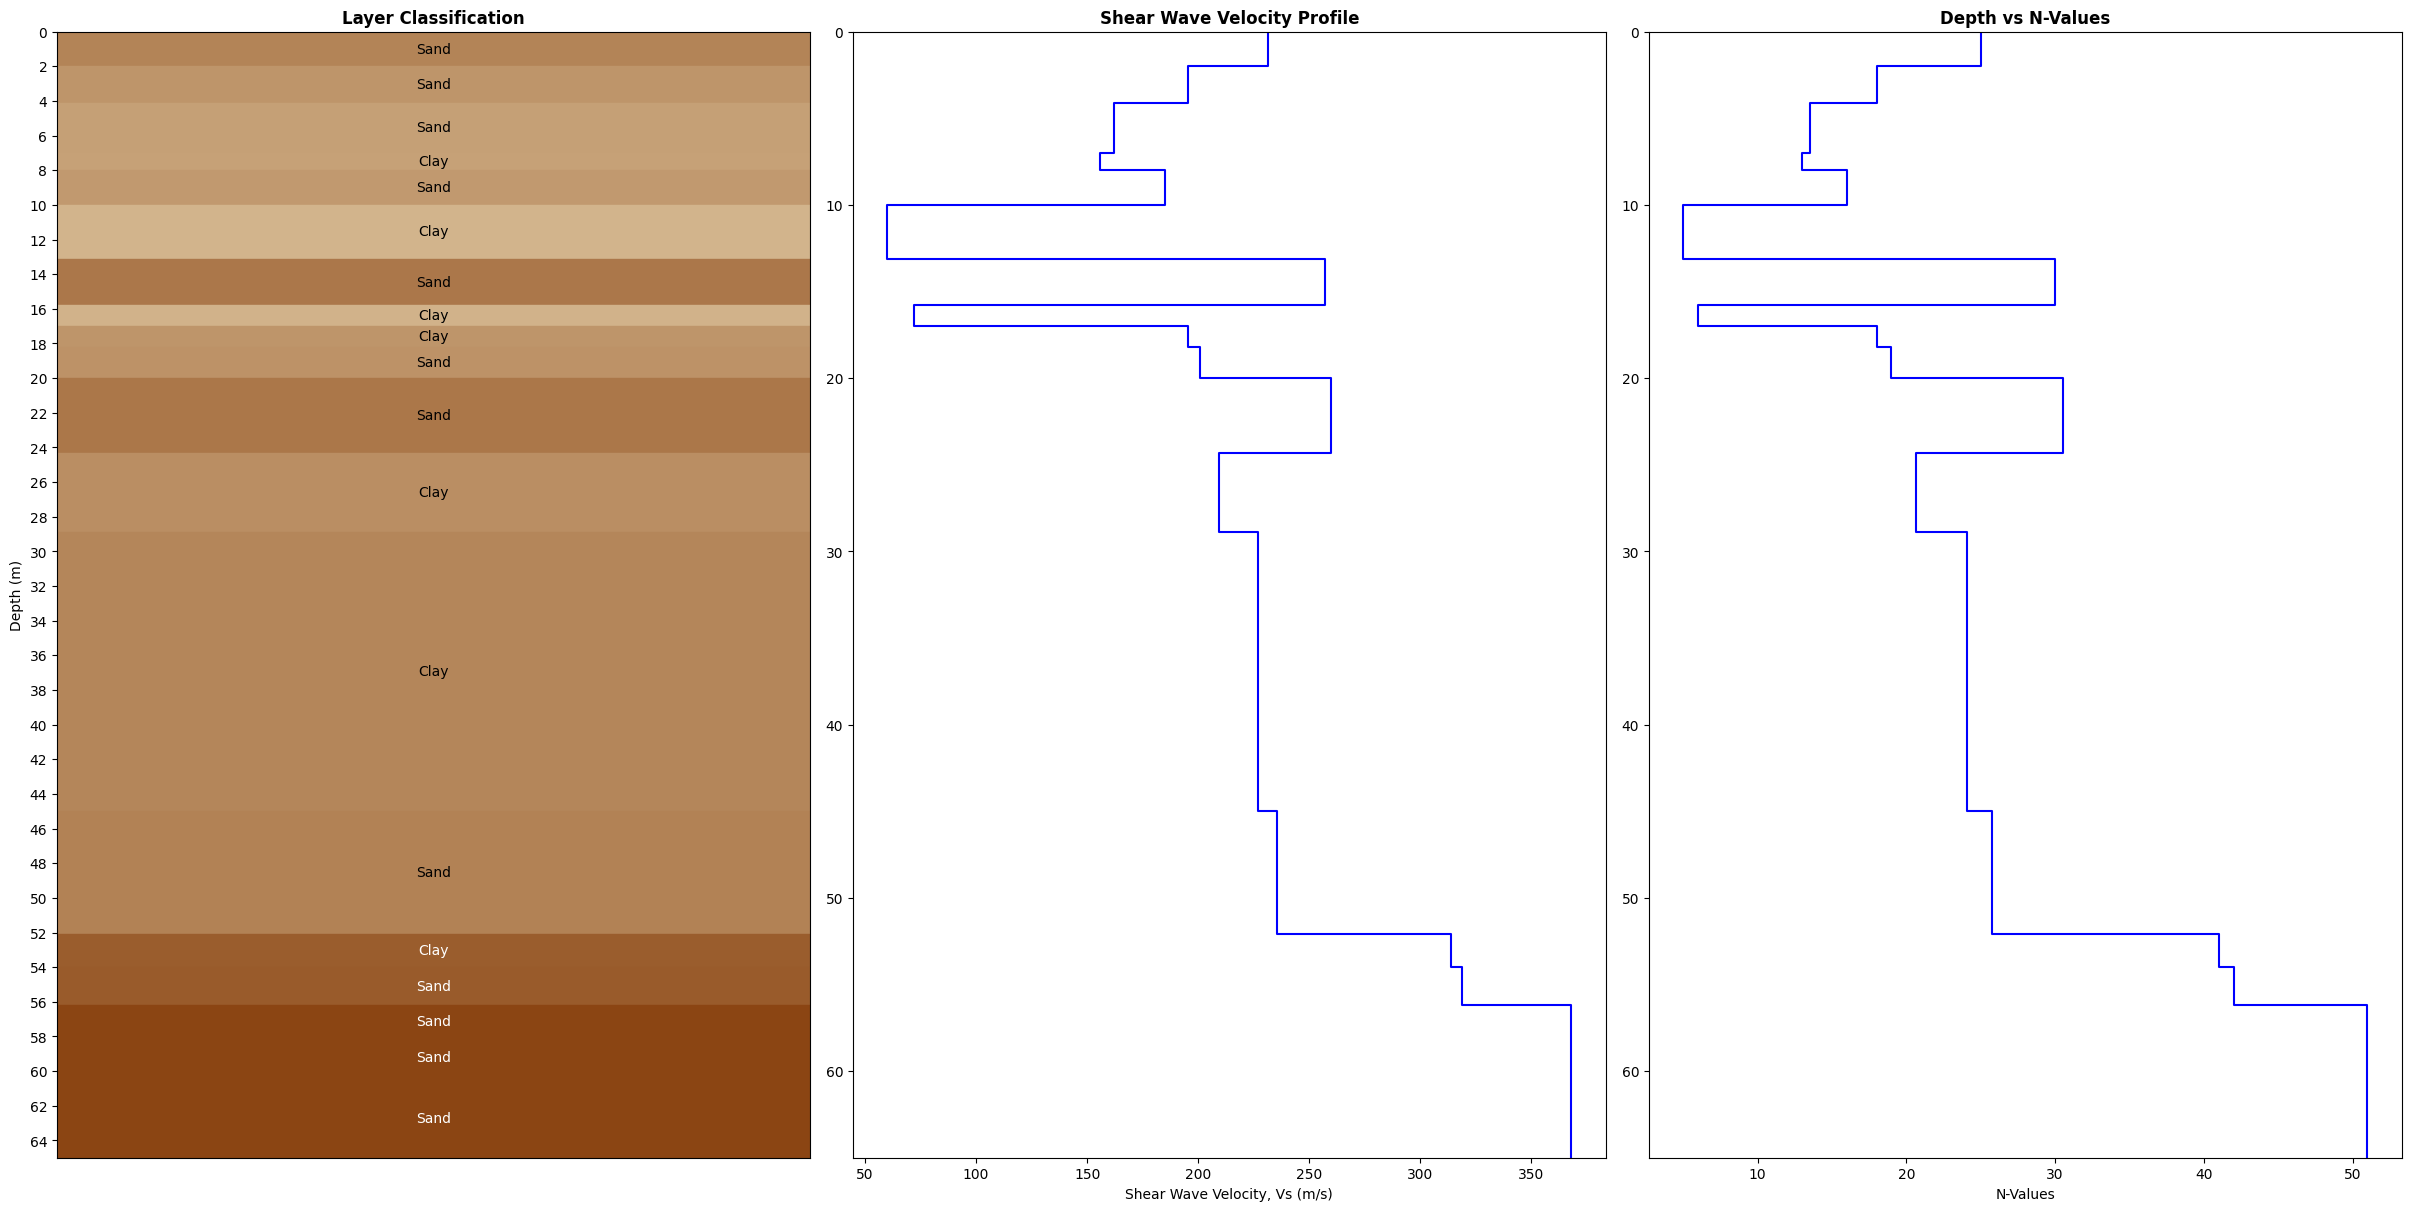

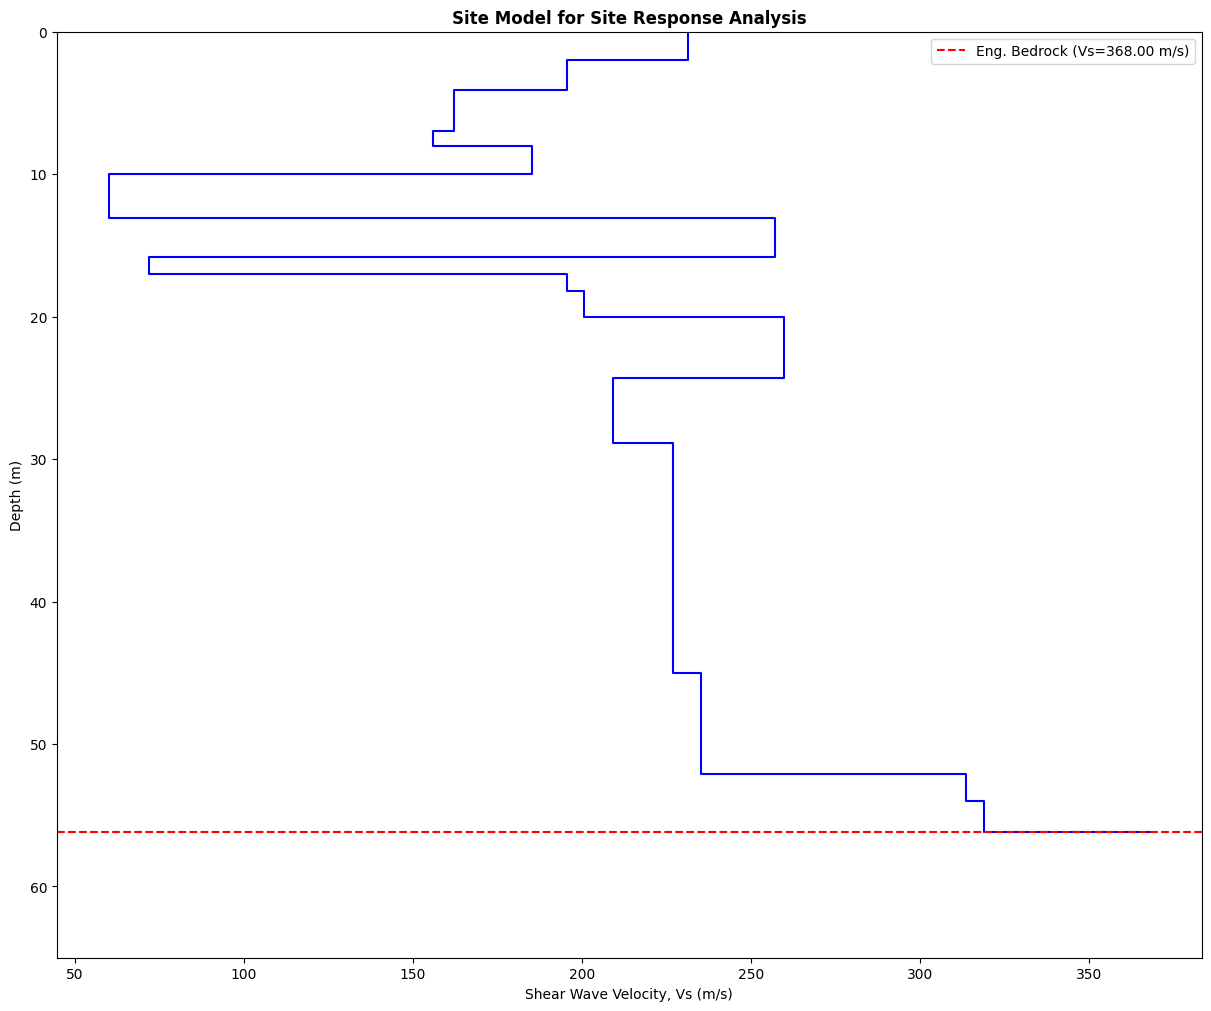

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import csv
from io import StringIO

# Example CSV data. Replace with your actual CSV content or a file path if needed.
csv_content = """Layer,Depth,Classification,Vs,N
1,0.00,Sand,231.43,25.00
1,2.00,Sand,231.43,25.00
2,2.00,Sand,195.43,18.00
2,4.10,Sand,195.43,18.00
3,4.10,Sand,162.00,13.50
3,7.00,Sand,162.00,13.50
4,7.00,Clay,156.00,13.00
4,8.00,Clay,156.00,13.00
5,8.00,Sand,185.14,16.00
5,10.00,Sand,185.14,16.00
6,10.00,Clay,60.00,5.00
6,13.10,Clay,60.00,5.00
7,13.10,Sand,257.14,30.00
7,15.80,Sand,257.14,30.00
8,15.80,Clay,72.00,6.00
8,17.00,Clay,72.00,6.00
9,17.00,Clay,195.43,18.00
9,18.20,Clay,195.43,18.00
10,18.20,Sand,200.57,19.00
10,20.00,Sand,200.57,19.00
11,20.00,Sand,259.71,30.50
11,24.30,Sand,259.71,30.50
12,24.30,Clay,209.14,20.67
12,28.90,Clay,209.14,20.67
13,28.90,Clay,226.86,24.11
13,45.00,Clay,226.86,24.11
14,45.00,Sand,235.29,25.75
14,52.10,Sand,235.29,25.75
15,52.10,Clay,313.71,41.00
15,54.00,Clay,313.71,41.00
16,54.00,Sand,318.86,42.00
16,56.20,Sand,318.86,42.00
17,56.20,Sand,368.00,51.00
17,58.00,Sand,368.00,51.00
18,58.00,Sand,368.00,51.00
18,60.40,Sand,368.00,51.00
19,60.40,Sand,368.00,51.00
19,65.00,Sand,368.00,51.00
"""

def get_contrast_text_color(rgb_color):
    """
    Returns 'white' if the color is dark and 'black' if the color is light.
    """
    brightness = 0.299 * rgb_color[0] + 0.587 * rgb_color[1] + 0.114 * rgb_color[2]
    return "white" if brightness < 0.5 else "black"

def plot_layer_classification(ax, layer_boundaries, layer_n, layer_vs, layer_classification, has_n_data):
    """
    Plots the layer classification as colored blocks along the depth axis.
    
    - If has_n_data is True, color each layer by its N-value (larger N => darker).
    - Otherwise, color by the layer's Vs value (larger Vs => darker).
    
    Uses a brown gradient from light (#d2b48c) to dark (#8B4513).
    """
    if has_n_data:
        min_val = min(layer_n)
        max_val = max(layer_n)
        data_array = layer_n
    else:
        min_val = min(layer_vs)
        max_val = max(layer_vs)
        data_array = layer_vs
    
    norm = mcolors.Normalize(min_val, max_val)
    brown_cmap = LinearSegmentedColormap.from_list("brown_shades", ["#d2b48c", "#8B4513"])
    
    for i, ((top, bottom), classification) in enumerate(zip(layer_boundaries, layer_classification)):
        val = data_array[i]
        layer_color = brown_cmap(norm(val))
        ax.fill_betweenx([top, bottom], 0, 1, color=layer_color)
        
        text_color = get_contrast_text_color(layer_color)
        mid_depth = (top + bottom) / 2
        ax.text(
            0.5,
            mid_depth,
            classification,
            fontsize=10,  # Slightly smaller font
            ha='center',
            va='center',
            color=text_color
        )
    
    overall_top = layer_boundaries[0][0]
    overall_bottom = layer_boundaries[-1][1]
    
    # Make sure top < bottom to avoid axis collapse
    if overall_bottom < overall_top:
        overall_top, overall_bottom = overall_bottom, overall_top
    
    ax.set_ylim(overall_bottom, overall_top)  # invert so depth increases downward
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    
    # Force integer ticks at every 2 meters (adjust if you prefer less/more granularity)
    ax.set_yticks(np.arange(int(overall_top), int(overall_bottom) + 1, 2))
    ax.tick_params(axis='y', labelsize=10)  # Smaller tick font
    ax.set_ylabel("Depth (m)", fontsize=10)
    ax.set_title("Layer Classification", fontsize=12, fontweight='bold')

def plot_shearwave_velocity(ax, depth, vs, title="Shear Wave Velocity Profile"):
    """
    Plots the shear wave velocity profile as a step plot (no markers).
    """
    ax.step(vs, depth, where='post', color='blue', linestyle='-')
    
    # Make sure we don't collapse the y-axis
    dmin, dmax = min(depth), max(depth)
    if dmax < dmin:
        dmin, dmax = dmax, dmin
    ax.set_ylim(dmax, dmin)  # invert y-axis
    ax.margins(y=0.1)
    
    ax.set_xlabel("Shear Wave Velocity, Vs (m/s)", fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')

def plot_n_values(ax, depth, n_values):
    """
    Plots the N-values as a step plot (no markers).
    """
    ax.step(n_values, depth, where='post', color='blue', linestyle='-')
    
    dmin, dmax = min(depth), max(depth)
    if dmax < dmin:
        dmin, dmax = dmax, dmin
    ax.set_ylim(dmax, dmin)
    ax.margins(y=0.1)
    
    ax.set_xlabel("N-Values", fontsize=10)
    ax.set_title("Depth vs N-Values", fontsize=12, fontweight='bold')

def truncate_profile(depth, vs, bedrock_depth):
    """
    Returns arrays of depth and vs only for depths <= bedrock_depth.
    """
    truncated_depth = []
    truncated_vs = []
    for d, v in zip(depth, vs):
        if d <= bedrock_depth:
            truncated_depth.append(d)
            truncated_vs.append(v)
        else:
            break
    return truncated_depth, truncated_vs

def main():
    # Read data
    csv_file = StringIO(csv_content)
    reader = csv.DictReader(csv_file)
    rows = list(reader)
    
    depth_all = []
    vs_all = []
    n_all = []
    has_n_data = True
    
    for row in rows:
        depth_val = float(row["Depth"]) if row["Depth"] else None
        vs_val = float(row["Vs"]) if row["Vs"] else None
        depth_all.append(depth_val)
        vs_all.append(vs_val)
        
        n_str = row["N"].strip() if row["N"] else ""
        if n_str == "":
            has_n_data = False
            n_all.append(None)
        else:
            try:
                n_val = float(n_str)
                n_all.append(n_val)
            except ValueError:
                has_n_data = False
                n_all.append(None)
    
    # Build layer boundaries
    layer_boundaries = []
    layer_n = []
    layer_vs = []
    layer_classification = []
    
    # Each layer has 2 lines in CSV. If that pattern differs, adjust here.
    for i in range(0, len(rows), 2):
        top = float(rows[i]["Depth"])
        bottom = float(rows[i+1]["Depth"])
        
        # Ensure top < bottom if data is reversed
        if bottom < top:
            top, bottom = bottom, top
        
        layer_boundaries.append((top, bottom))
        
        if has_n_data:
            n_val = float(rows[i]["N"])
        else:
            n_val = 1.0
        vs_val_layer = float(rows[i]["Vs"])
        
        layer_n.append(n_val)
        layer_vs.append(vs_val_layer)
        layer_classification.append(rows[i]["Classification"])
    
    # 1) Find max Vs & identify "engineering bedrock"
    max_vs = max(vs_all)
    max_vs_index = vs_all.index(max_vs)
    max_vs_depth = depth_all[max_vs_index]
    
    engineering_bedrock_depth = None
    for (top, bottom) in layer_boundaries:
        if top <= max_vs_depth < bottom:
            engineering_bedrock_depth = top
            break
    
    print(f"Maximum Vs: {max_vs:.2f} m/s")
    if engineering_bedrock_depth is not None:
        print(f"Depth to Engineering Bedrock: {engineering_bedrock_depth:.2f} m")
    else:
        print("Could not identify engineering bedrock layer from the data.")
    
    # 2) Plot the Original Profiles (3-Subplot Layout)
    # ------------------------------------------------
    # Increase figure size; use constrained_layout or switch to tight_layout if needed:
    fig, axes = plt.subplots(
        1,
        3,
        figsize=(24, 12),            # WIDER/TALLER to accommodate 73m depth
        constrained_layout=True      # If you still get warnings, comment this out
    )

    # If constrained_layout still warns about collapsed axes,
    # switch to tight_layout:
    # fig, axes = plt.subplots(1, 3, figsize=(24, 12))
    # # after plotting, use:
    # plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.97])

    # Plot classification
    plot_layer_classification(
        axes[0],
        layer_boundaries,
        layer_n,
        layer_vs,
        layer_classification,
        has_n_data=has_n_data
    )

    # Plot Vs
    plot_shearwave_velocity(
        axes[1],
        depth_all,
        vs_all,
        "Shear Wave Velocity Profile"
    )

    # If we have N-data, plot it
    if has_n_data:
        plot_n_values(axes[2], depth_all, n_all)
    else:
        # If no N-data, you might only have 2 subplots
        # But leaving as 3 subplots is okay; the 3rd subplot stays empty.
        pass

    plt.show()

    # 3) Plot the Site Model (Second Figure)
    # --------------------------------------
    # For the site model, we show the entire depth range (0 to max depth),
    # but the blue Vs step plot stops at engineering bedrock.
    if engineering_bedrock_depth is not None:
        truncated_depth, truncated_vs = truncate_profile(depth_all, vs_all, engineering_bedrock_depth)
    else:
        truncated_depth, truncated_vs = depth_all, vs_all
    
    fig2, ax2 = plt.subplots(
        figsize=(12, 10), 
        constrained_layout=True  # or use tight_layout
    )

    plot_shearwave_velocity(
        ax2,
        truncated_depth,
        truncated_vs,
        "Site Model for Site Response Analysis"
    )
    
    # Reset y-axis to full depth range
    dmin, dmax = min(depth_all), max(depth_all)
    if dmax < dmin:
        dmin, dmax = dmax, dmin
    ax2.set_ylim(dmax, dmin)
    ax2.set_ylabel("Depth (m)", fontsize=10)
    
    # Add a line at the bedrock depth
    if engineering_bedrock_depth is not None:
        ax2.axhline(
            y=engineering_bedrock_depth,
            color='red',
            linestyle='--',
            label=f'Eng. Bedrock (Vs={max_vs:.2f} m/s)'
        )
        ax2.legend(loc='best')

    plt.show()

# Run the main function
if __name__ == "__main__":
    main()
